In [ ]:
import time
import os
import torchvision
import numpy as np

import torch
import torch.nn.functional as F
import torch.nn as nn


from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms

from PIL import Image
import matplotlib.pyplot as plt

In [ ]:
Batch_size = 128

custom_transform1 = transforms.Compose([transforms.Resize([64, 64]),
                                        transforms.ToTensor()])
train_dataset = torchvision.datasets.FashionMNIST(
    root='./ImageNet',
    train=True,
    download=True,
    transform=custom_transform1
)
test_dataset = torchvision.datasets.FashionMNIST(
    root='./ImageNet',
    train=False,
    download=True,
    transform=custom_transform1
)
# define train loader
train_loader = DataLoader(
    dataset=train_dataset,
    shuffle=True,
    batch_size=Batch_size
)
test_loader = DataLoader(
    dataset=test_dataset,
    shuffle=True,
    batch_size=Batch_size
)



for images, labels in train_loader:
    print(images.shape)
    print(labels.shape)
    break

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./ImageNet/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./ImageNet/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./ImageNet/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./ImageNet/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./ImageNet/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./ImageNet/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./ImageNet/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./ImageNet/FashionMNIST/raw

torch.Size([128, 1, 64, 64])
torch.Size([128])


In [ ]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
DEVICE

device(type='cuda')

In [ ]:
class VGG16(torch.nn.Module):

    def __init__(self, num_classes):
        super(VGG16, self).__init__()
        
        # calculate same padding:
        # (w - k + 2*p)/s + 1 = o
        # => p = (s(o-1) - w + k)/2
        
        self.block_1 = nn.Sequential(
                nn.Conv2d(in_channels=1,
                          out_channels=64,
                          kernel_size=(3, 3),
                          stride=(1, 1),
                          # (1(32-1)- 32 + 3)/2 = 1
                          padding=1), 
                nn.ReLU(),
                nn.Conv2d(in_channels=64,
                          out_channels=64,
                          kernel_size=(3, 3),
                          stride=(1, 1),
                          padding=1),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=(2, 2),
                             stride=(2, 2))
        )
        
        self.block_2 = nn.Sequential(
                nn.Conv2d(in_channels=64,
                          out_channels=128,
                          kernel_size=(3, 3),
                          stride=(1, 1),
                          padding=1),
                nn.ReLU(),
                nn.Conv2d(in_channels=128,
                          out_channels=128,
                          kernel_size=(3, 3),
                          stride=(1, 1),
                          padding=1),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=(2, 2),
                             stride=(2, 2))
        )
        
        self.block_3 = nn.Sequential(        
                nn.Conv2d(in_channels=128,
                          out_channels=256,
                          kernel_size=(3, 3),
                          stride=(1, 1),
                          padding=1),
                nn.ReLU(),
                nn.Conv2d(in_channels=256,
                          out_channels=256,
                          kernel_size=(3, 3),
                          stride=(1, 1),
                          padding=1),
                nn.ReLU(),        
                nn.Conv2d(in_channels=256,
                          out_channels=256,
                          kernel_size=(3, 3),
                          stride=(1, 1),
                          padding=1),
                nn.ReLU(),
                nn.Conv2d(in_channels=256,
                          out_channels=256,
                          kernel_size=(3, 3),
                          stride=(1, 1),
                          padding=1),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=(2, 2),
                             stride=(2, 2))
        )
        
          
        self.block_4 = nn.Sequential(   
                nn.Conv2d(in_channels=256,
                          out_channels=512,
                          kernel_size=(3, 3),
                          stride=(1, 1),
                          padding=1),
                nn.ReLU(),        
                nn.Conv2d(in_channels=512,
                          out_channels=512,
                          kernel_size=(3, 3),
                          stride=(1, 1),
                          padding=1),
                nn.ReLU(),        
                nn.Conv2d(in_channels=512,
                          out_channels=512,
                          kernel_size=(3, 3),
                          stride=(1, 1),
                          padding=1),
                nn.ReLU(),
                nn.Conv2d(in_channels=512,
                          out_channels=512,
                          kernel_size=(3, 3),
                          stride=(1, 1),
                          padding=1),
                nn.ReLU(),   
                nn.MaxPool2d(kernel_size=(2, 2),
                             stride=(2, 2))
        )
        
        self.block_5 = nn.Sequential(
                nn.Conv2d(in_channels=512,
                          out_channels=512,
                          kernel_size=(3, 3),
                          stride=(1, 1),
                          padding=1),
                nn.ReLU(),            
                nn.Conv2d(in_channels=512,
                          out_channels=512,
                          kernel_size=(3, 3),
                          stride=(1, 1),
                          padding=1),
                nn.ReLU(),            
                nn.Conv2d(in_channels=512,
                          out_channels=512,
                          kernel_size=(3, 3),
                          stride=(1, 1),
                          padding=1),
                nn.ReLU(),
                nn.Conv2d(in_channels=512,
                          out_channels=512,
                          kernel_size=(3, 3),
                          stride=(1, 1),
                          padding=1),
                nn.ReLU(),   
                nn.MaxPool2d(kernel_size=(2, 2),
                             stride=(2, 2))             
        )
        
        self.classifier = nn.Sequential(
                nn.Linear(512*2*2, 4096),
                nn.ReLU(),   
                nn.Linear(4096, 4096),
                nn.ReLU(),
                nn.Linear(4096, num_classes)
        )
        for m in self.modules():
            if isinstance(m, torch.nn.Conv2d):
                #n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                #m.weight.data.normal_(0, np.sqrt(2. / n))
                m.weight.detach().normal_(0, 0.05)
                if m.bias is not None:
                    m.bias.detach().zero_()
            elif isinstance(m, torch.nn.Linear):
                m.weight.detach().normal_(0, 0.05)
                m.bias.detach().detach().zero_()
        
    def forward(self, x):

        x = self.block_1(x)
        x = self.block_2(x)
        x = self.block_3(x)
        x = self.block_4(x)
        x = self.block_5(x)

        logits = self.classifier(x.view(-1, 512*2*2))
        probas = F.softmax(logits, dim=1)

        return logits,probas


In [ ]:
NUM_EPOCHS = 30
model = VGG16(num_classes=10)
model = model.to(DEVICE)
# sgd training was originally chosen here. ， but the effect is very poor, replace it with Adam just optimize it. 
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
valid_loader = test_loader

In [ ]:
def compute_accuracy_and_loss(model, data_loader, device):
    correct_pred, num_examples = 0, 0
    cross_entropy = 0.
    for i, (features, targets) in enumerate(data_loader):
            
        features = features.to(device)
        targets = targets.to(device)

        logits, probas = model(features)
        cross_entropy += F.cross_entropy(logits, targets).item()
        _, predicted_labels = torch.max(probas, 1)
        num_examples += targets.size(0)
        correct_pred += (predicted_labels == targets).sum()
    return correct_pred.float()/num_examples * 100, cross_entropy/num_examples
    

start_time = time.time()
train_acc_lst, valid_acc_lst = np.zeros(NUM_EPOCHS), np.zeros(NUM_EPOCHS)
train_loss_lst, valid_loss_lst = [], []

for epoch in range(NUM_EPOCHS):
    
    model.train()
    
    for batch_idx, (features, targets) in enumerate(train_loader):
    
        ### PREPARE MINIBATCH
        features = features.to(DEVICE)
        targets = targets.to(DEVICE)
            
        ### FORWARD AND BACK PROP
        logits, probas = model(features)
        cost = F.cross_entropy(logits, targets)
        optimizer.zero_grad()
        
        cost.backward()
        
        ### UPDATE MODEL PARAMETERS
        optimizer.step()
        
        ### LOGGING
        if not batch_idx % 120:
            print (f'Epoch: {epoch+1:03d}/{NUM_EPOCHS:03d} | '
                   f'Batch {batch_idx:03d}/{len(train_loader):03d} |' 
                   f' Cost: {cost:.4f}')

    # no need to build the computation graph for backprop when computing accuracy
    model.eval()
    with torch.set_grad_enabled(False):
        train_acc, train_loss = compute_accuracy_and_loss(model, train_loader, device=DEVICE)
        valid_acc, valid_loss = compute_accuracy_and_loss(model, valid_loader, device=DEVICE)
        train_acc_lst[epoch] = train_acc
        valid_acc_lst[epoch] = valid_acc
        train_loss_lst.append(train_loss)
        valid_loss_lst.append(valid_loss)
        print(f'Epoch: {epoch+1:03d}/{NUM_EPOCHS:03d} Train Acc.: {train_acc:.2f}%'
              f' | Validation Acc.: {valid_acc:.2f}%')
        
    elapsed = (time.time() - start_time)/60
    print(f'Time elapsed: {elapsed:.2f} min')
  
elapsed = (time.time() - start_time)/60
print(f'Total Training Time: {elapsed:.2f} min')

Epoch: 001/030 | Batch 000/469 | Cost: 2192.0312
Epoch: 001/030 | Batch 120/469 | Cost: 0.6645
Epoch: 001/030 | Batch 240/469 | Cost: 0.5900
Epoch: 001/030 | Batch 360/469 | Cost: 0.5299
Epoch: 001/030 Train Acc.: 84.82% | Validation Acc.: 83.68%
Time elapsed: 1.97 min
Epoch: 002/030 | Batch 000/469 | Cost: 0.3437
Epoch: 002/030 | Batch 120/469 | Cost: 0.4486
Epoch: 002/030 | Batch 240/469 | Cost: 0.3508
Epoch: 002/030 | Batch 360/469 | Cost: 0.3487
Epoch: 002/030 Train Acc.: 87.42% | Validation Acc.: 86.22%
Time elapsed: 4.02 min
Epoch: 003/030 | Batch 000/469 | Cost: 0.2963
Epoch: 003/030 | Batch 120/469 | Cost: 0.2760
Epoch: 003/030 | Batch 240/469 | Cost: 0.3481
Epoch: 003/030 | Batch 360/469 | Cost: 0.2427
Epoch: 003/030 Train Acc.: 89.79% | Validation Acc.: 88.59%
Time elapsed: 6.09 min
Epoch: 004/030 | Batch 000/469 | Cost: 0.3192
Epoch: 004/030 | Batch 120/469 | Cost: 0.2744
Epoch: 004/030 | Batch 240/469 | Cost: 0.3781
Epoch: 004/030 | Batch 360/469 | Cost: 0.2840
Epoch: 004/0

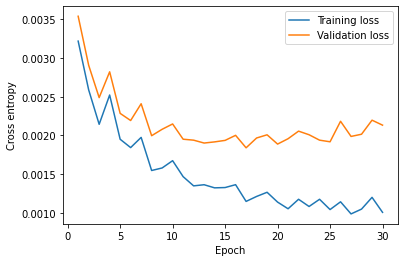

In [ ]:
plt.plot(range(1, NUM_EPOCHS+1), train_loss_lst, label='Training loss')
plt.plot(range(1, NUM_EPOCHS+1), valid_loss_lst, label='Validation loss')
plt.legend(loc='upper right')
plt.ylabel('Cross entropy')
plt.xlabel('Epoch')
plt.show()

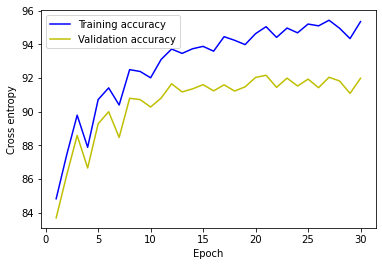

In [ ]:
plt.plot(range(1, NUM_EPOCHS+1), train_acc_lst, label='Training accuracy', color = 'b')
plt.plot(range(1, NUM_EPOCHS+1), valid_acc_lst, label='Validation accuracy', color = 'y')
plt.legend(loc='upper left')
plt.ylabel('Cross entropy')
plt.xlabel('Epoch')
plt.show()


In [ ]:
model.eval()
with torch.set_grad_enabled(False): # save memory during inference
    test_acc, test_loss = compute_accuracy_and_loss(model, test_loader, DEVICE)
    print(f'Test accuracy: {test_acc:.2f}%')

Test accuracy: 91.99%


In [ ]:
test_loader = DataLoader(dataset=train_dataset, 
                         batch_size=64, 
                         shuffle=True)

for features, targets in test_loader:
    break
    

_, predictions = model.forward(features[:8].to(DEVICE))
predictions = torch.argmax(predictions, dim=1)


torch.Size([64, 1, 64, 64])


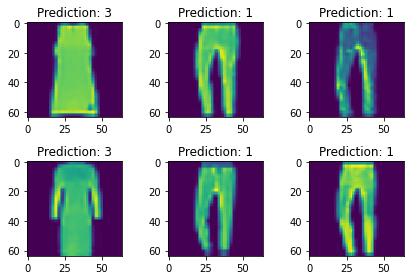

In [ ]:
print(features.size())
fig = plt.figure()
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    plt.imshow(features[i][0],interpolation='none')
    plt.title("Prediction: {}".format(predictions[i]))
plt.show()

In [ ]:
model

VGG16(
  (block_1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (block_3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
